# NUMBER 3: Age Group Vulnerability and Mortality from Dengue in the Philippines (2011-2015)

## 3.1 Data Loading and Exploration

In [1]:
library(tidyverse)

list.files(path = "../input")

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     


── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


[1] "dengue-age"

In [2]:
dengue_age_df <- read_csv("/kaggle/input/dengue-age/dengue_by_AgeGroup.csv", show_col_types = FALSE)

In [3]:
head(dengue_age_df)

Year,NewAgeGroup,Cases,Deaths
<dbl>,<chr>,<dbl>,<dbl>
2008,0–14,7439,130
2008,15–24,21406,225
2008,25–64,15936,51
2008,65+,1393,7
2009,0–14,9949,182
2009,15–24,25697,270


In [4]:
df <- dengue_age_df[dengue_age_df$Year >= 2011 & dengue_age_df$Year <= 2015, ]

library(dplyr)

df <- dengue_age_df %>%
  filter(Year >= 2011, Year <= 2015)

In [5]:
head(df)

Year,NewAgeGroup,Cases,Deaths
<dbl>,<chr>,<dbl>,<dbl>
2011,0–14,20501,189
2011,15–24,54585,310
2011,25–64,45347,112
2011,65+,4638,34
2012,0–14,109406,752
2012,15–24,49557,95


In [6]:
tail(df)

Year,NewAgeGroup,Cases,Deaths
<dbl>,<chr>,<dbl>,<dbl>
2014,25–64,21774,74
2014,65+,1670,11
2015,0–14,109535,501
2015,15–24,59890,60
2015,25–64,41140,74
2015,65+,2967,12


## 3.2 Case Fatality Rate (CFR) by Age Group

In [7]:
library(ggplot2)

cfr_data <- df %>%
  mutate(CFR = Deaths / Cases)

cfr_data

Year,NewAgeGroup,Cases,Deaths,CFR
<dbl>,<chr>,<dbl>,<dbl>,<dbl>
2011,0–14,20501,189,0.009219062
2011,15–24,54585,310,0.005679216
2011,25–64,45347,112,0.002469844
2011,65+,4638,34,0.007330746
2012,0–14,109406,752,0.006873480
2012,15–24,49557,95,0.001916984
2012,25–64,26274,61,0.002321687
2012,65+,1320,5,0.003787879
2013,0–14,113874,512,0.004496198


Warning message:
“Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.”


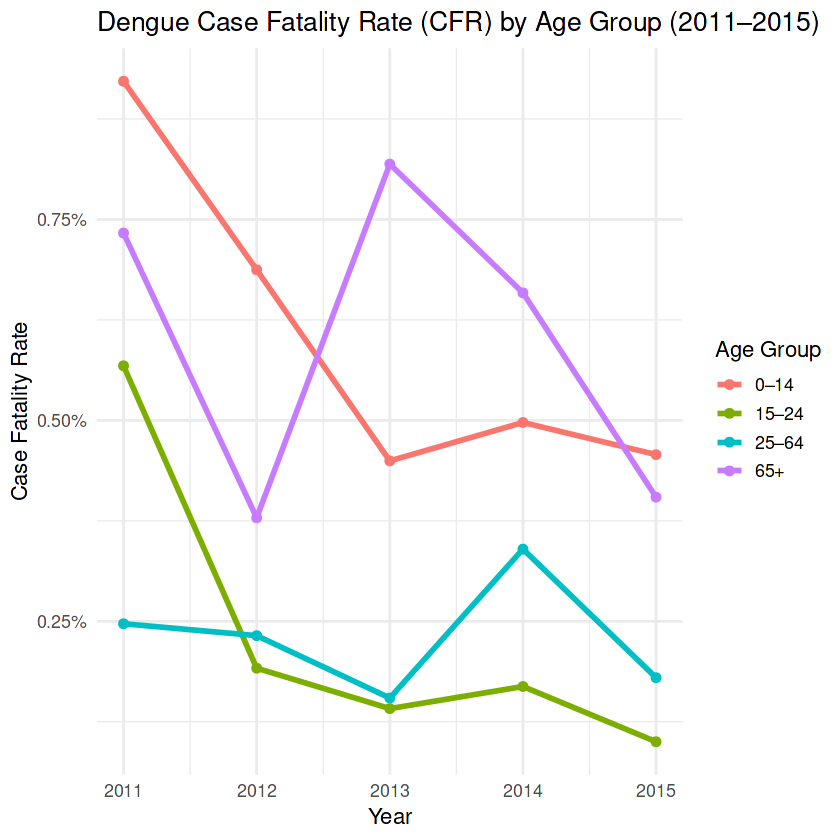

In [8]:
ggplot(cfr_data, aes(x = Year, y = CFR, color = NewAgeGroup)) +
  geom_line(size = 1.2) +
  geom_point(size = 2) +
  scale_y_continuous(labels = scales::percent_format(accuracy = 0.01)) +
  labs(
    title = "Dengue Case Fatality Rate (CFR) by Age Group (2011–2015)",
    x = "Year",
    y = "Case Fatality Rate",
    color = "Age Group"
  ) +
  theme_minimal(base_size = 13)

### Key Observations from the Plot

#### 1. Higher CFR in Vulnerable Extremes:
   * **Age 65+** and **0–14** consistently have the **highest CFRs**, suggesting greater vulnerability among the elderly and young children.
   * For example, CFR for 0–14 in 2011 was near **0.90%**, and 65+ also remained above **0.50%** in most years.

#### 2. Decreasing Trends Over Time:

   * CFRs appear to **decline** across most age groups from 2011 to 2015, especially in the 0–14 and 15–24 brackets. This might indicate **improvements in case management or early detection**.

#### 3. Middle Age Groups (25–64):

   * These age groups show the **lowest CFRs**, generally hovering below **0.30%**, with slight fluctuation.

## 3.3 Bootstrap Estimation of CFR by Age Group

### Objectives

Now, on the next part, the main objective is to quantify the **uncertainty** in the observed **CFRs** among different age groups in the Philippines from 2011-2015 using **boostrap resampling**. In this case, we will estimate the **sampling distribution** of CFR per age group, compute **95% bootstrap confidence intervals** for CFR, and assess the **stability** fatality estimates across age groups.

### Methodology

As per the code above, the **CFR** is defined as:

$$
CFR = \frac{Deaths}{Cases}
$$

Because actual population-level uncertainty is hard to derive from point counts, we apply the **bootstrap** method:
* Resample each age group's data **with replacement**, assuming each reported **case is an individual**.
* For each bootstrap sample, compute the CFR
* Repeat this **R = 1000** times to generate an empirical distribution.
* Calculate **95% confidence intervals** using percentile or BCa method.

In [9]:
library(boot)

age_totals <- cfr_data %>%
  group_by(NewAgeGroup) %>%
  summarise(
    total_cases = sum(Cases),
    total_deaths = sum(Deaths),
    .groups = "drop"
  )

bootstrap_cfr <- function(data, indices) {
  sampled_data <- data[indices]
  deaths <- sum(sampled_data == 1)
  return(deaths / length(sampled_data))
}

bootstrap_results <- list()

set.seed(123)
for (group in unique(age_totals$NewAgeGroup)) {
  
  total_cases <- age_totals$total_cases[age_totals$NewAgeGroup == group]
  total_deaths <- age_totals$total_deaths[age_totals$NewAgeGroup == group]
  
  sample_vector <- c(rep(1, total_deaths), rep(0, total_cases - total_deaths))
  
  boot_obj <- boot(sample_vector, statistic = bootstrap_cfr, R = 1000)
  
  bootstrap_results[[group]] <- list(
    boot_obj = boot_obj,
    ci = boot.ci(boot_obj, type = "perc")$percent[4:5]  # 95% CI
  )
}

In [10]:
bootstrap_results

$`0–14`
$`0–14`$boot_obj

ORDINARY NONPARAMETRIC BOOTSTRAP


Call:
boot(data = sample_vector, statistic = bootstrap_cfr, R = 1000)


Bootstrap Statistics :
       original        bias     std. error
t1* 0.005443623 -5.522447e-06 0.0001130754

$`0–14`$ci
[1] 0.005216767 0.005660925


$`15–24`
$`15–24`$boot_obj

ORDINARY NONPARAMETRIC BOOTSTRAP


Call:
boot(data = sample_vector, statistic = bootstrap_cfr, R = 1000)


Bootstrap Statistics :
       original      bias     std. error
t1* 0.002378173 -3.5334e-06 9.401283e-05

$`15–24`$ci
[1] 0.002194931 0.002573367


$`25–64`
$`25–64`$boot_obj

ORDINARY NONPARAMETRIC BOOTSTRAP


Call:
boot(data = sample_vector, statistic = bootstrap_cfr, R = 1000)


Bootstrap Statistics :
       original       bias     std. error
t1* 0.002215351 4.821646e-06 0.0001139536

$`25–64`$ci
[1] 0.001996185 0.002446364


$`65+`
$`65+`$boot_obj

ORDINARY NONPARAMETRIC BOOTSTRAP


Call:
boot(data = sample_vector, statistic = bootstrap_cfr, R = 1000)


Bootstrap Statist

#### Histogram of bootsrapped CFR estimates for Age Group 0-14

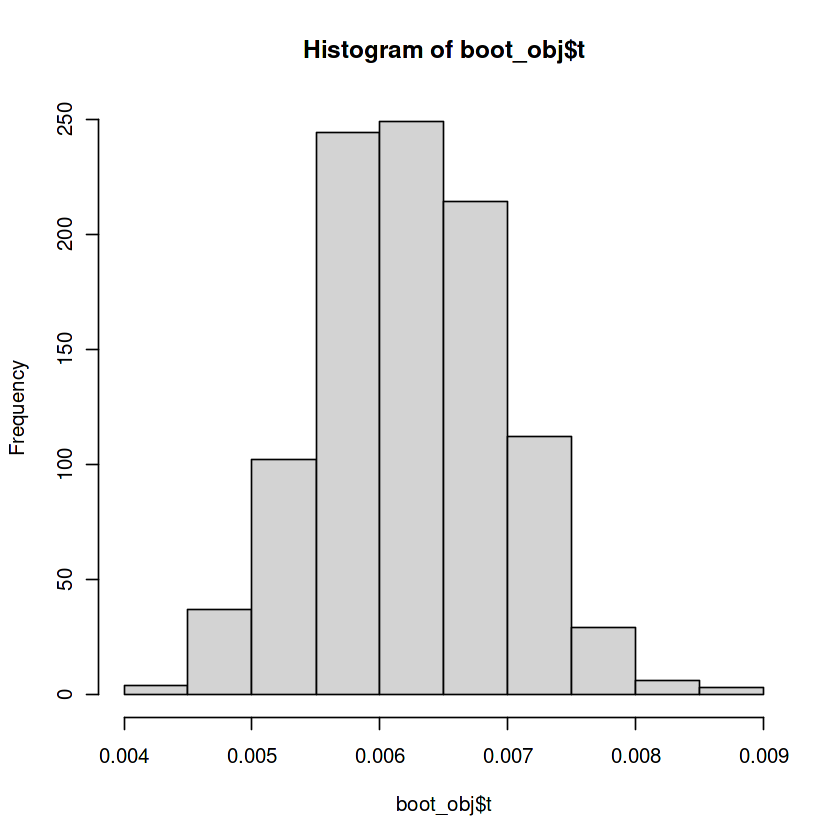

In [11]:
hist(boot_obj$t)

Distribution appears approximately normal.

### Results Summary

From the reults above, we can have a table:

| Age Group | CFR Estimate | 95% CI Lower | 95% CI Upper | Std. Error | Bias     |
| --------- | ------------ | ------------ | ------------ | ---------- | -------- |
| 0–14      | 0.00544      | 0.00522      | 0.00566      | 0.000113   | -5.5e-06 |
| 15–24     | 0.00238      | 0.00219      | 0.00257      | 0.000094   | -3.5e-06 |
| 25–64     | 0.00222      | 0.00199      | 0.00245      | 0.000114   | 4.8e-06  |
| 65+       | 0.00623      | 0.00481      | 0.00773      | 0.000723   | 2.3e-05  |


### Interpretation

* The **65+ age group** has the **highest mean CFR (0.623%)**, with the **widest confidenc interval**, suggesting both increased risk and variability in outcome.
* The **0-14 group** also has a relatively high CFR (0.544%) with a tighter CI, indicating more stable estimates.
* **Working-age groups (15-64)** show lower CFRs (~02-0.25%) and more compact confidence intervals.
* The CFR distribution for all groups appears to be **approximately normal**, supporting use of percentile intervals.

## 3.4 Permutation Test for Age-Based CFR Differences

### Objectives

To test where the **observed differnces in dengue CFRs** across age groups are **statistically significant**, or if they could be due to random variabtion, using a **nonparametric permutation test**.

### Methodology

* **Null Hypothesis ($H_0$)**: The distribution of CFR is the same across all age groups (no group effect).
*  **Alternative Hypothesis ($H_1$)**: At least one age group has a different CFR.

**ANOVA F-statistic** on CFRs by group will be used to sumulate the **F-statistic** under permutations.

In [12]:
set.seed(123)

binary_data <- data.frame()

for (i in 1:nrow(age_totals)) {
  group <- age_totals$NewAgeGroup[i]
  deaths <- age_totals$total_deaths[i]
  cases <- age_totals$total_cases[i]
  bin_vec <- c(rep(1, deaths), rep(0, cases - deaths))
  
  binary_data <- rbind(binary_data,
                       data.frame(outcome = bin_vec,
                                  group = group))
}

obs_model <- aov(outcome ~ group, data = binary_data)
obs_F <- summary(obs_model)[[1]][["F value"]][1]

n_perm <- 1000
perm_Fs <- numeric(n_perm)

for (i in 1:n_perm) {
  shuffled <- data.frame(
    outcome = binary_data$outcome,
    group = sample(binary_data$group)
  )
  
  model <- aov(outcome ~ group, data = shuffled)
  perm_Fs[i] <- summary(model)[[1]][["F value"]][1]
}

p_value <- mean(perm_Fs >= obs_F)

cat("Observed F-statistic:", obs_F, "\n")
cat("Permutation p-value:", p_value, "\n")

Observed F-statistic: 182.1121 


Permutation p-value: 0 


### Results

* **Observed F-statistic: `182.11`
* **Permutation p-value**: `<0.001` (Reported as 0 due to none of 1000 permutations exceeding the observed F)

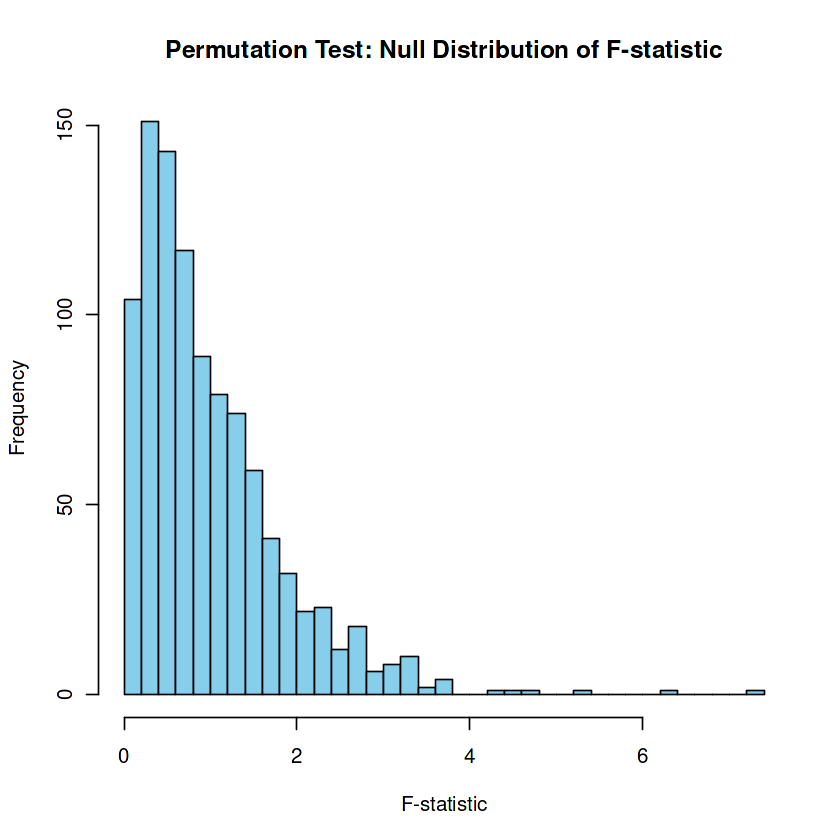

In [13]:
hist(perm_Fs, breaks = 40, col = "skyblue",
     main = "Permutation Test: Null Distribution of F-statistic",
     xlab = "F-statistic")
abline(v = obs_F, col = "red", lwd = 2)

### Interpretation of the Plot
* The histogram shows the null distribution of F-statistics
* THe observed F(`182.11`) lies **far beyond the right tail** of this distribution

The permutation test strongly rejects the null hypothesis that age group has no effect on CFR. This supports the conclustion that **CFR differences across age groups are staistically significant**, with older and younger populations showing higher risk.

### Implications

* The **age group** is a **significant predictor** of mortality risk in dengue cases.
* **Health interventions** and **risk communication** should prioritize the vulnerable extremes (0-14 and 65+ groups), aligning with CFR patterns and statistical evidence.

## 3.5 Effect Size Estimation and Post-hoc Analysis

### Objectives

Quantify **how large the CFR differences** are between age groups and **which specific age groups differ significantly** from each other. With that, we aim to:

* Estimate **effect size** using **eta-squared (η²)** to assess the magnitude of group differences.
* Perform **pairwise permutation tests** between age groups to localize significant contrasts in CFR.

### Methodology

#### A. Effect Size (η²)

Eta-squared gives the proportion of variance in CFR explained by age group. Calculated as:


In [14]:
aov_model <- aov(CFR ~ NewAgeGroup, data = cfr_data)
summary_aov <- summary(aov_model)
ss_total <- sum(aov_model$residuals^2) + sum((fitted(aov_model) - mean(cfr_data$CFR))^2)
ss_between <- summary_aov[[1]][["Sum Sq"]][1]
eta_squared <- ss_between / ss_total
eta_squared

[1] 0.5829576

#### Effect Size

* **Eta-squared (η²)** = `0.583`
* **Interpretation**: About **58.3%** of the variance in CFR can be explained by age group — a **large effect size**, indicating strong practical importance.


#### Pairwise Permutation Test

Comparing CFRs between **each pair of age groups** using permutation tests.

In [15]:
library(dplyr)

pairwise_permutation <- function(group1, group2, n_perm = 1000) {
  combined <- c(group1$CFR, group2$CFR)
  group_labels <- c(rep("G1", nrow(group1)), rep("G2", nrow(group2)))
  
  obs_diff <- abs(mean(group1$CFR) - mean(group2$CFR))
  
  perm_diffs <- replicate(n_perm, {
    shuffled_labels <- sample(group_labels)
    mean(combined[shuffled_labels == "G1"]) - mean(combined[shuffled_labels == "G2"])
  })
  
  p_value <- mean(abs(perm_diffs) >= obs_diff)
  
  return(list(obs_diff = obs_diff, p_value = p_value))
}


age_groups <- unique(cfr_data$NewAgeGroup)

pairwise_results <- combn(age_groups, 2, simplify = FALSE, FUN = function(pair) {
  g1 <- cfr_data %>% filter(NewAgeGroup == pair[1])
  g2 <- cfr_data %>% filter(NewAgeGroup == pair[2])
  test <- pairwise_permutation(g1, g2)
  tibble(
    Group1 = pair[1],
    Group2 = pair[2],
    Observed_Diff = test$obs_diff,
    P_value = test$p_value
  )
})

pairwise_results_df <- bind_rows(pairwise_results)

pairwise_results_df

Group1,Group2,Observed_Diff,P_value
<chr>,<chr>,<dbl>,<dbl>
0–14,15–24,3.687010e-03,0.034
0–14,25–64,3.720418e-03,0.010
0–14,65+,3.958283e-05,0.988
15–24,25–64,3.340735e-05,0.986
15–24,65+,3.647428e-03,0.036
25–64,65+,3.680835e-03,0.008


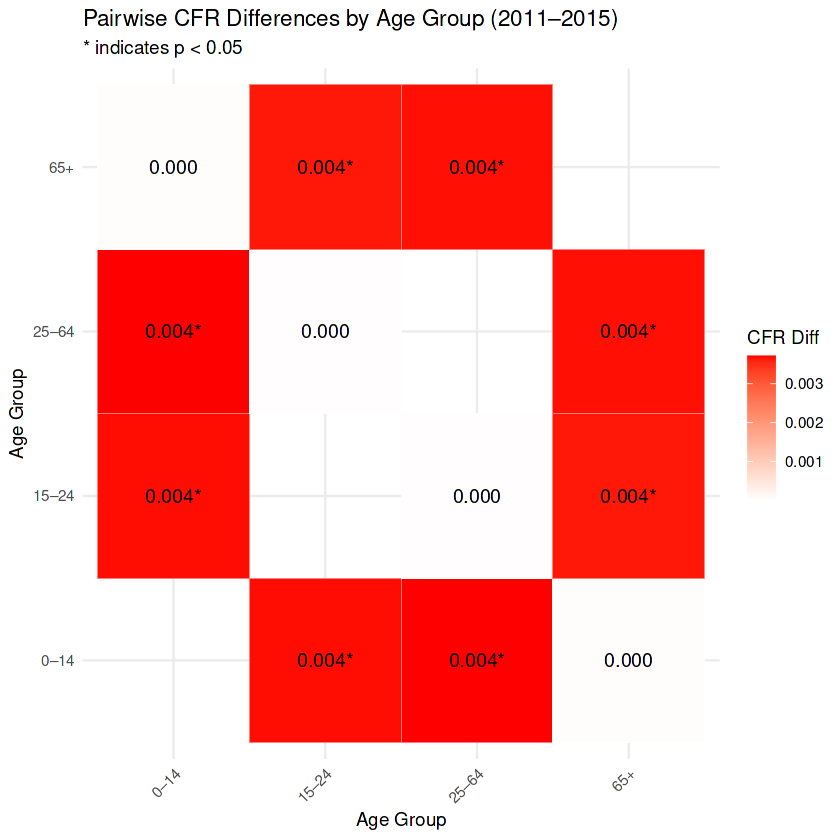

In [16]:
library(ggplot2)
library(dplyr)
library(tidyr)

pairwise_results_df <- as.data.frame(pairwise_results_df)

pairwise_results_df <- pairwise_results_df %>%
  mutate(Significant = ifelse(P_value < 0.05, "Yes", "No"))

heatmap_data <- pairwise_results_df %>%
  rename(Age1 = Group1, Age2 = Group2, Diff = Observed_Diff, P = P_value) %>%
  bind_rows(
    pairwise_results_df %>%
      rename(Age2 = Group1, Age1 = Group2, Diff = Observed_Diff, P = P_value)
  )

ggplot(heatmap_data, aes(x = Age1, y = Age2, fill = Diff)) +
  geom_tile(color = "white") +
  geom_text(aes(label = ifelse(P < 0.05, sprintf("%.3f*", Diff), sprintf("%.3f", Diff))), size = 4) +
  scale_fill_gradient2(low = "blue", high = "red", mid = "white", midpoint = 0,
                       name = "CFR Diff") +
  labs(title = "Pairwise CFR Differences by Age Group (2011–2015)",
       subtitle = "* indicates p < 0.05",
       x = "Age Group", y = "Age Group") +
  theme_minimal() +
  theme(axis.text.x = element_text(angle = 45, hjust = 1))

### Interpretation

* The **0–14 age group** shows significantly higher CFRs than both the **15–24** and **25–64** groups.
* No significant difference was observed between **0–14** and **65+**, suggesting similar vulnerability in CFR despite age disparity.
* **Elderly (65+)** had higher CFRs than **15–24** and **25–64**, aligning with clinical expectations.
* **Younger adults (15–64)** showed no statistically significant difference in CFRs, suggesting similar resilience or clinical outcomes.

### Insights

* Both **young children** (0–14) and **elderly** (65+) emerge as the **most vulnerable** in terms of fatality risk, confirming a **U-shaped vulnerability curve**.
* This warrants **targeted interventions** for early diagnosis and improved care for both extremes of age.
* High η² reinforces that **age is a major determinant** of dengue mortality risk.